In [1]:
!pip install catalax

In [2]:
import json
import jax.numpy as jnp
import catalax as ctx
import catalax.neural as ctn
from tqdm import tqdm
import numpy as np
import catalax as ctx
import catalax.mcmc as cmc
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import catalax as ctx
import catalax.neural as cnn
import catalax.mcmc as cmc
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import Divider, Size

ctx.set_host_count(10)

# Pretraining 

In [3]:
# Initialize the model
model = ctx.Model(name="PGM ENO")

# Add species
model.add_species("s0")
model.add_species("s1")
model.add_species("s2")

# Add ODEs
model.add_ode("s0", "- (vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))")
model.add_ode("s1", 
              """(vf_pgm/k_p3ga_pgm)*(s0-s1/keq_pgm)/(1+(s1/k_p2ga_pgm)+(s0/k_p3ga_pgm))
              - (vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))
              """
             )
model.add_ode("s2", "(vf_eno/k_p2ga_eno)*(s1-s2/keq_eno)/(1+(s1/k_p2ga_eno)+(s2/k_PEP_eno))")

# Prepare the model for bayes and define priors 
model.parameters.vf_eno.value = 1.35
model.parameters.vf_pgm.value = 9.4
model.parameters.keq_pgm.value = 0.19
model.parameters.keq_eno.value = 6.7
model.parameters.k_p2ga_pgm.value = 0.08
model.parameters.k_p3ga_pgm.value = 1.2
model.parameters.k_p2ga_eno.value = 0.04
model.parameters.k_PEP_eno.value = 0.5

model

Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[keq_pgm, vf_pgm, k_p3ga_pgm, k_p2ga_pgm, k_p2ga_eno, keq_eno, k_PEP_eno, vf_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

name      symbol  value  constant initial_value equation lower_bound  \
0   k_PEP_eno   k_PEP_eno   0.50     False          None     None        None   
1  k_p2ga_eno  k_p2ga_eno   0.04     False          None     None        None   
2  k_p2ga_pgm  k_p2ga_pgm   0.08     False          None     None        None   
3  k_p3ga_pgm  k_p3ga_pgm   1.20     False          None     None        None   
4     keq_eno     keq_eno   6.70     False          None     None        None   
5     keq_pgm     keq_pgm   0.19     False          None     None        None   
6      vf_eno      vf_eno   1.35     False          None     None        None   
7      vf_pgm      vf_pgm   9.40     False          None     None        None   

  upper_bound  
0        None  
1        None  
2        None  
3        None  
4        None  
5        None  
6        None  
7        None

## Training Set 

In [4]:
data = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 4/Data_Testing_Set_4_20242309.npy")
time = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 4/Time_Testing_Set_4_20242309.npy")
y0s = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 4/Testing_Set_4_Initials_20242309.npy")
initial_conditions = json.load(open("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/Testing Set 4/Corrected_model_4_20242309.json", "r"))  
print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")
print(data.shape)
print(time.shape)
print(y0s.shape)




Time: (30, 15) | Data: (30, 15, 3) | Initial Conditions: (30, 3)
(30, 15, 3)
(30, 15)
(30, 3)


## Validation set 

In [5]:
val_data = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/B and C/Validation_Set_B_and_C_20242309.npy")
val_time = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/B and C/Time_Validation_Set_B_and_C_20242309.npy")
val_y0s = jnp.load("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/B and C/Validation_Set_B_and_C_Initials_20242309.npy")
val_initial_conditions = json.load(open("C:/Users/danic/Thesis/Data/Testing and Validation Arrays/B and C/model_Validation_Set_B_and_C_20242309.json", "r"))     

# HMC 

In [6]:
#HERE WE TRAIN THE MCMC ON THE DATA INDEPENDANT OF THE NEURAL ODE TO SEE HOW THE NDE COMPARES TO THE HMC

In [7]:
# Assuming `trained_model` is your trained Neural ODE model
model


Model summary


Eq(x, Matrix([[s0, s1, s2]]))

Eq(theta, Matrix([[keq_pgm, vf_pgm, k_p3ga_pgm, k_p2ga_pgm, k_p2ga_eno, keq_eno, k_PEP_eno, vf_eno]]))

Eq(Derivative(s0, t), -vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)))

Eq(Derivative(s1, t), vf_pgm*(s0 - s1/keq_pgm)/(k_p3ga_pgm*(1 + s0/k_p3ga_pgm + s1/k_p2ga_pgm)) - vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

Eq(Derivative(s2, t), vf_eno*(s1 - s2/keq_eno)/(k_p2ga_eno*(1 + s1/k_p2ga_eno + s2/k_PEP_eno)))

name      symbol  value  constant initial_value equation lower_bound  \
0   k_PEP_eno   k_PEP_eno   0.50     False          None     None        None   
1  k_p2ga_eno  k_p2ga_eno   0.04     False          None     None        None   
2  k_p2ga_pgm  k_p2ga_pgm   0.08     False          None     None        None   
3  k_p3ga_pgm  k_p3ga_pgm   1.20     False          None     None        None   
4     keq_eno     keq_eno   6.70     False          None     None        None   
5     keq_pgm     keq_pgm   0.19     False          None     None        None   
6      vf_eno      vf_eno   1.35     False          None     None        None   
7      vf_pgm      vf_pgm   9.40     False          None     None        None   

  upper_bound  
0        None  
1        None  
2        None  
3        None  
4        None  
5        None  
6        None  
7        None

In [8]:
model.parameters.vf_eno.value = 1.35
model.parameters.vf_pgm.value = 9.4
model.parameters.keq_pgm.value = 0.19
model.parameters.keq_eno.value = 6.7
model.parameters.k_p2ga_pgm.value = 0.08
model.parameters.k_p3ga_pgm.value = 1.2
model.parameters.k_p2ga_eno.value = 0.04
model.parameters.k_PEP_eno.value = 0.5

In [9]:
# Define Priors

model.parameters.vf_eno.prior = cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.vf_pgm.prior= cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.keq_pgm.prior= cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_p2ga_pgm.prior = cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_p3ga_pgm.prior = cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_p2ga_eno.prior =cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.k_PEP_eno.prior=cmc.priors.Uniform(low=1e-3, high=1e1)
model.parameters.keq_eno.prior=cmc.priors.Uniform(low=1e-3, high=1e1)


# Save the model and its priors
model.save("C:/Users/danic/OneDrive/Desktop", "menten_model_w_priors_Mel")

In [10]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=2000,
    num_samples=1000,
    dt0=0.1,
    max_steps=64**4
)

🔸 Priors
├── keq_pgm: U(low=0.001, high=10.0)
├── vf_pgm: U(low=0.001, high=10.0)
├── k_p3ga_pgm: U(low=0.001, high=10.0)
├── k_p2ga_pgm: U(low=0.001, high=10.0)
├── k_p2ga_eno: U(low=0.001, high=10.0)
├── keq_eno: U(low=0.001, high=10.0)
├── k_PEP_eno: U(low=0.001, high=10.0)
├── vf_eno: U(low=0.001, high=10.0)

🚀 Running MCMC



sample: 100%|███████████████████████████| 3000/3000 [47:04<00:00,  1.06it/s, 15 steps of size 6.78e-02. acc. prob=0.88]




🎉 Finished

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
   k_PEP_eno      4.15      1.79      3.88      1.11      6.76    288.73      1.00
  k_p2ga_eno      5.58      1.98      5.47      2.69      9.11    481.40      1.00
  k_p2ga_pgm      0.06      0.03      0.05      0.01      0.10    207.88      1.00
  k_p3ga_pgm      8.23      1.55      8.66      5.90      9.99     93.27      1.00
     keq_eno      4.15      0.20      4.16      3.82      4.46    756.28      1.00
     keq_pgm      0.13      0.01      0.13      0.11      0.14    522.24      1.00
       sigma      0.93      0.02      0.93      0.90      0.95    831.03      1.00
      vf_eno      7.92      1.60      8.23      5.48      9.99    606.64      1.00
      vf_pgm      5.88      2.21      5.63      3.07      9.91    141.10      1.00

Number of divergences: 9


In [11]:
##### Add parameters to the model
for param, samples in mcmc.get_samples().items():
    if param not in model.parameters:
        continue
    
    model.parameters[param].value = float(samples.mean())
    
model.parameters

name      symbol     value  constant initial_value equation  \
0   k_PEP_eno   k_PEP_eno  4.146517     False          None     None   
1  k_p2ga_eno  k_p2ga_eno  5.578436     False          None     None   
2  k_p2ga_pgm  k_p2ga_pgm  0.055063     False          None     None   
3  k_p3ga_pgm  k_p3ga_pgm  8.231624     False          None     None   
4     keq_eno     keq_eno  4.152942     False          None     None   
5     keq_pgm     keq_pgm  0.128205     False          None     None   
6      vf_eno      vf_eno  7.916929     False          None     None   
7      vf_pgm      vf_pgm  5.878975     False          None     None   

  lower_bound upper_bound  
0        None        None  
1        None        None  
2        None        None  
3        None        None  
4        None        None  
5        None        None  
6        None        None  
7        None        None

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\corner\core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
C:\Users\danic\anaconda3\envs\test\Lib\site-packages\catalax\mcmc\plotting.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


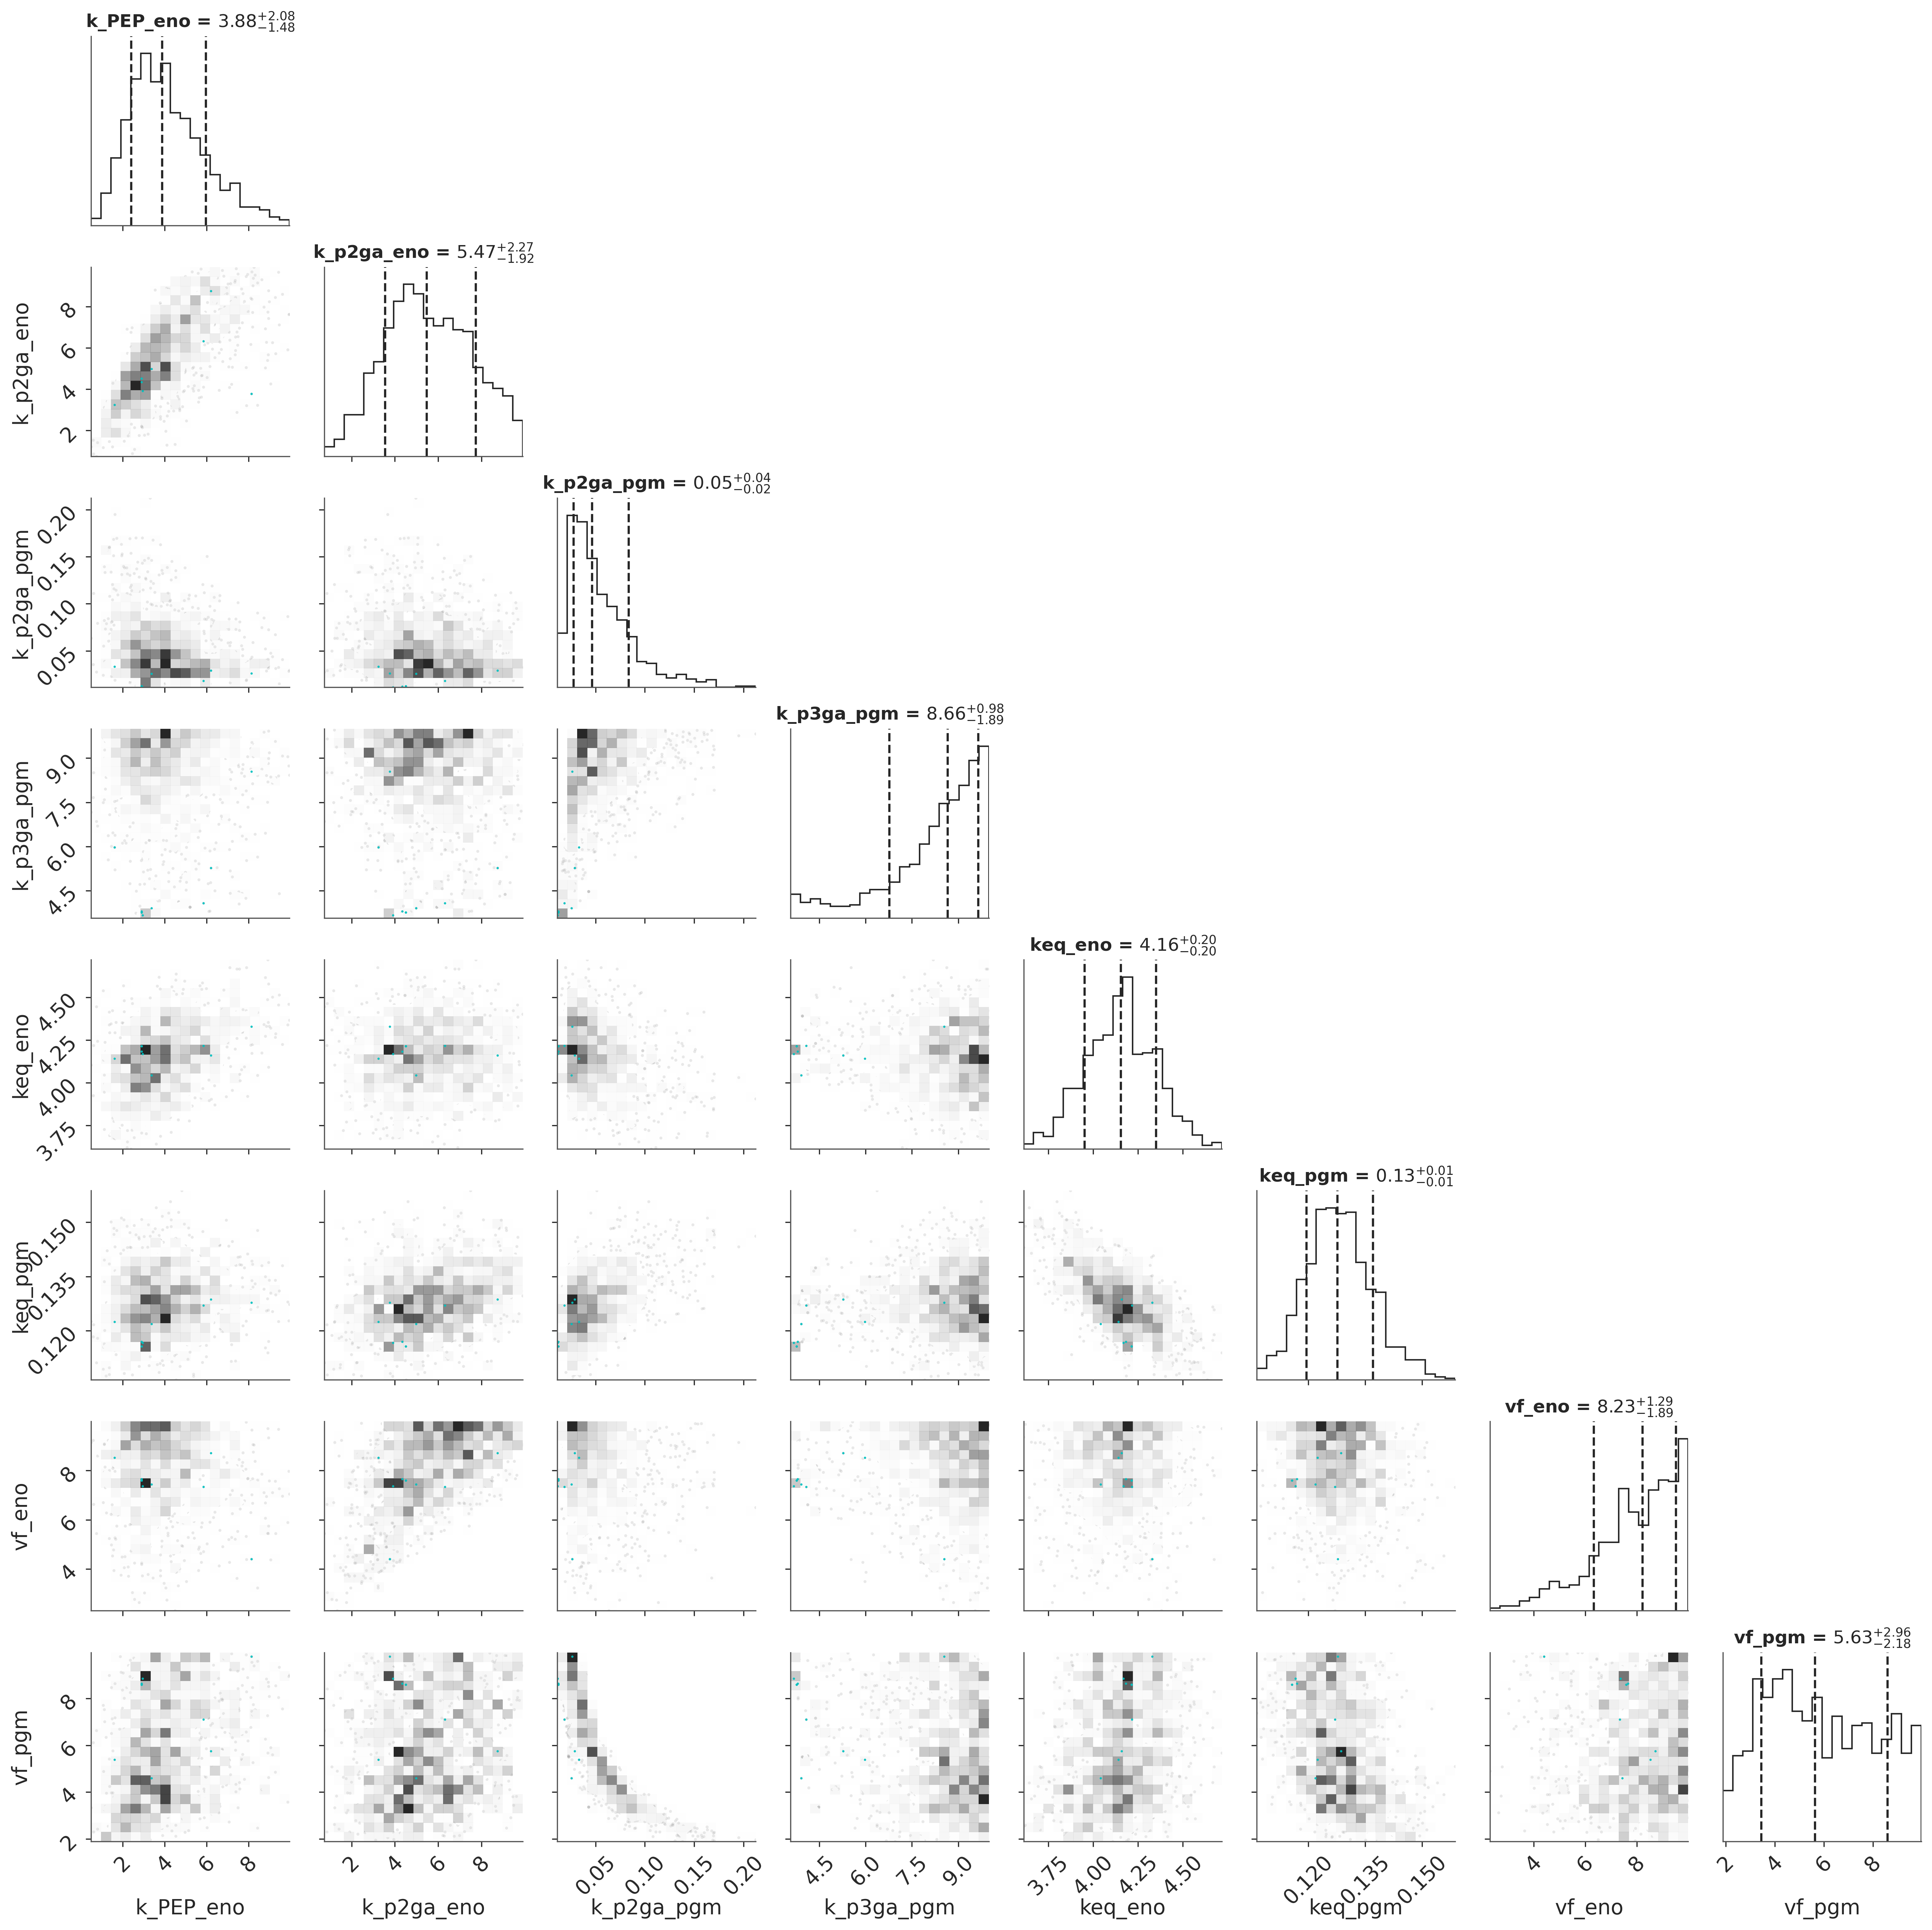

In [12]:
# Visualize the result using a corner plot
# Shows the posterior distribution of the parameters
# Shows the correlation between the parameters
fig = cmc.plot_corner(mcmc)

In [13]:
fig.savefig("C:/Users/danic/Thesis/Data/Corner_Plot_Set3_MCMC.png", dpi=300, bbox_inches="tight")

In [14]:
f = ctx.visualize(
    model=model,
    data=data,
    times=time,
    initial_conditions=initial_conditions,
    figsize=(8,4),
    mcmc=mcmc
)

C:\Users\danic\anaconda3\envs\test\Lib\site-packages\IPython\core\events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
C:\Users\danic\anaconda3\envs\test\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


In [15]:
f.set_figwidth(9)
f.set_figheight()


TypeError: Figure.set_figheight() missing 1 required positional argument: 'val'

In [ ]:
f

In [ ]:
import pickle
# Save the file to a specific directory
with open("C:/Users/danic/Thesis/Data/Training_Set_3_Params_visualization.pkl", "wb") as file:
    pickle.dump(f, file)


In [ ]:
f.savefig("C:/Users/danic/Thesis/Data/Params_Set3_MCMC.png", dpi=300, bbox_inches="tight")

## HMC + NDE

In [ ]:
#here we combine the HMC results in the NDE 

In [ ]:
#Here we set the priors for the Monte Carlo to the parameter values generated by the NDE

model.parameters.vf_eno.value = 1.3
model.parameters.vf_pgm.value = 9.26
model.parameters.keq_pgm.value = 0.09
model.parameters.keq_eno.value = 4.6
model.parameters.k_p2ga_pgm.value = 0.38
model.parameters.k_p3ga_pgm.value = 1.62
model.parameters.k_p2ga_eno.value = 0.95
model.parameters.k_PEP_eno.value = 1.2

In [ ]:
# Define Priors

model.parameters.vf_eno.prior = cmc.priors.Uniform(low=1e-6, high=1e3)
model.parameters.vf_pgm.prior= cmc.priors.Uniform(low=1e-6, high=1e3)
model.parameters.keq_pgm.prior= cmc.priors.Uniform(low=1e-6, high=1e3)
model.parameters.k_p2ga_pgm.prior = cmc.priors.Uniform(low=1e-6, high=1e3)
model.parameters.k_p3ga_pgm.prior = cmc.priors.Uniform(low=1e-6, high=1e3)
model.parameters.k_p2ga_eno.prior =cmc.priors.Uniform(low=1e-6, high=1e3)
model.parameters.k_PEP_eno.prior=cmc.priors.Uniform(low=1e-6, high=1e3)
model.parameters.keq_eno.prior=cmc.priors.Uniform(low=1e-6, high=1e3)


In [ ]:
# Perform MCMC simulation
mcmc, bayes_model = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=2.0,
    num_warmup=2000,
    num_samples=1000,
    dt0=0.3,
    max_steps=64**4
)